In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray
from metloom.pointdata import SnotelPointData, USGSPointData
import seaborn as sns

## To-Do List

- Restrict to 2011-2014
- Restrict to January-April
- Investigate the rolling mean function
- 

In [3]:
# include area plot 
# places where two snotels disagree 
# are there times when one site predicts snow and another predicts rain on snow at one time 
# see what temperature these things happen at 
# future work, make multiclass 
# visual of what rain on snow looks like, what characterizes it 
# plot: one axis has discharge, another has temp
# correlation matrix 
# january 1st through april 1st

In [ ]:
# pip install metloom

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install pint_xarray

Note: you may need to restart the kernel to use updated packages.


In [6]:
# we will look at january through april 
# predict discharge based on the snotel data
# spike in discharge means rain on snow, we will have 2 classes, so binary classification
# final goal: get a decision tree to predict discharge spikes based on snotel data 
# truth rain from snotel, infer it from discharge


# SWE: snow water equivalent: determines how much water the snowpack contains

### Prediction

#### Predict discharge based on the snotel data

In [68]:
# do some cleaning, we've got some null values 
# null values will be replaced with the mean of the row before and after it

def fill_null(df):
    df = df.copy()
    df = df.reset_index()
    for col in df.columns:
        print("cleaning ", col)
        null_indices = df[df[col].isnull()].index
        for i in null_indices:
            before = df.loc[i-1, col] if i > 0 else np.nan
            after = df.loc[i+1, col] if i < len(df) - 1 else np.nan

            #Handle cases where either before or after is also NaN
            valid_values = [x for x in [before, after] if pd.notna(x)]
            if valid_values:
              df.loc[i, col] = np.mean(valid_values)
            #If both before and after are NaN, leave the NaN as is

    print(df)
    return df

## Start here with the backfilled data

In [69]:
snotel_hourly = xr.open_dataset('../../data/snotel/snotel_hourly_backfill_1980_2024.zarr')
usgs_hourly = xr.open_dataset('../../data/stream/usgs_instantaneous_backfill_1980_2024.zarr')
usgs_hourly

/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/pro

<xarray.Dataset> Size: 27MB
Dimensions:       (site: 2, date: 1134647)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ... 2024-01-0...
Data variables:
    DISCHARGE     (date, site) float64 18MB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [70]:
# only keep 2019-2024

snotel_month_filtered = snotel_hourly.sel(date=snotel_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))
discharge_month_filtered = usgs_hourly.sel(date=usgs_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))

In [71]:
discharge_month_filtered

<xarray.Dataset> Size: 1MB
Dimensions:       (site: 2, date: 59060)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 472kB 2019-01-01 ... 2024-01-02T07:45:00
Data variables:
    DISCHARGE     (date, site) float64 945kB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [72]:
# line up usgs discharge with their correct sites 

discharge = []
discharge_by_site = discharge_month_filtered.DISCHARGE.values
dishcarge_thunder = discharge_by_site[:,0]
dishcarge_beaver = discharge_by_site[:,1]
for i in range(0,len(dishcarge_thunder)):
    discharge.append(dishcarge_thunder[i])
    discharge.append(dishcarge_beaver[i])

In [73]:
# add discharge to the SNOTEL data 
snotel_hourly_gdf = snotel_month_filtered.to_dataframe().reset_index()
snotel_hourly_numeric = snotel_hourly_gdf.copy()
snotel_hourly_numeric['DISCHARGE'] = discharge
snotel_hourly_numeric


,date,site,ACCUMULATED PRECIPITATION,site_name,SNOWDEPTH,elevation_ft,SWE,lat,AIR TEMP,lon,DISCHARGE
0,2019-01-01 00:00:00,817:WA:SNTL,31.2,Beaver Creek,50.0,4310.0,15.2,48.528,12.56,-120.990,247.0
1,2019-01-01 00:00:00,990:WA:SNTL,35.6,Thunder Basin,56.0,3630.0,16.2,48.879,22.28,-121.256,240.0
2,2019-01-01 00:05:00,817:WA:SNTL,31.2,Beaver Creek,49.0,4310.0,15.2,48.528,10.94,-120.990,249.0
3,2019-01-01 00:05:00,990:WA:SNTL,35.5,Thunder Basin,56.0,3630.0,16.2,48.879,21.38,-121.256,NaN
4,2019-01-01 00:10:00,817:WA:SNTL,31.2,Beaver Creek,49.0,4310.0,15.2,48.528,10.94,-120.990,249.0
...,...,...,...,...,...,...,...,...,...,...,...
118115,2024-01-02 07:15:00,990:WA:SNTL,NaN,Thunder Basin,NaN,3630.0,NaN,48.879,NaN,-121.256,210.0
118116,2024-01-02 07:30:00,817:WA:SNTL,NaN,Beaver Creek,NaN,4310.0,NaN,48.528,NaN,-120.990,220.0
118117,2024-01-02 07:30:00,990:WA:SNTL,NaN,Thunder Basin,NaN,3630.0,NaN,48.879,NaN,-121.256,208.0
118118,2024-01-02 07:45:00,817:WA:SNTL,NaN,Beaver Creek,NaN,4310.0,NaN,48.528,NaN,-120.990,220.0


In [74]:
#grouped_by_site = snotel_hourly_numeric.groupby('site_name')

grouped_by_site = snotel_hourly_numeric.sort_values(['site','date'],ascending=True).groupby('site')
grouped_by_site =grouped_by_site.apply(pd.DataFrame)
grouped_by_site

/var/folders/28/n2khkrt15537q1z3stgtj5200000gn/T/ipykernel_18952/3260400871.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_by_site =grouped_by_site.apply(pd.DataFrame)


date         site  \
site                                                  
817:WA:SNTL 0      2019-01-01 00:00:00  817:WA:SNTL   
            2      2019-01-01 00:05:00  817:WA:SNTL   
            4      2019-01-01 00:10:00  817:WA:SNTL   
            6      2019-01-01 00:15:00  817:WA:SNTL   
            8      2019-01-01 00:20:00  817:WA:SNTL   
...                                ...          ...   
990:WA:SNTL 118111 2024-01-02 06:45:00  990:WA:SNTL   
            118113 2024-01-02 07:00:00  990:WA:SNTL   
            118115 2024-01-02 07:15:00  990:WA:SNTL   
            118117 2024-01-02 07:30:00  990:WA:SNTL   
            118119 2024-01-02 07:45:00  990:WA:SNTL   

                    ACCUMULATED PRECIPITATION      site_name  SNOWDEPTH  \
site                                                                      
817:WA:SNTL 0                            31.2   Beaver Creek       50.0   
            2                            31.2   Beaver Creek       49.0   
            4                            31.2   Beaver Creek       49.0   
            6                            31.2   Beaver Creek       49.0   
            8                            31.2   Beaver Creek       49.0   
...                                       ...            ...        ...   
990:WA:SNTL 118111                        NaN  Thunder Basin        NaN   
            118113                        NaN  Thunder Basin        NaN   
            118115                        NaN  Thunder Basin        NaN   
            118117                        NaN  Thunder Basin        NaN   
            118119                        NaN  Thunder Basin        NaN   

                    elevation_ft   SWE     lat  AIR TEMP      lon  DISCHARGE  
site                                                                          
817:WA:SNTL 0             4310.0  15.2  48.528     12.56 -120.990      247.0  
            2             4310.0  15.2  48.528     10.94 -120.990      249.0  
            4             4310.0  15.2  48.528     10.94 -120.990      249.0  
            6             4310.0  15.2  48.528     10.94 -120.990      249.0  
            8             4310.0  15.2  48.528     10.94 -120.990      247.0  
...                          ...   ...     ...       ...      ...        ...  
990:WA:SNTL 118111        3630.0   NaN  48.879       NaN -121.256      208.0  
            118113        3630.0   NaN  48.879       NaN -121.256      210.0  
            118115        3630.0   NaN  48.879       NaN -121.256      210.0  
            118117        3630.0   NaN  48.879       NaN -121.256      208.0  
            118119        3630.0   NaN  48.879       NaN -121.256      208.0  

[118120 rows x 11 columns]

In [75]:
# only keep numeric data 

data_numeric = grouped_by_site.filter(items=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'])

In [76]:
data_numeric

ACCUMULATED PRECIPITATION   SWE  AIR TEMP  DISCHARGE
site                                                                    
817:WA:SNTL 0                            31.2  15.2     12.56      247.0
            2                            31.2  15.2     10.94      249.0
            4                            31.2  15.2     10.94      249.0
            6                            31.2  15.2     10.94      249.0
            8                            31.2  15.2     10.94      247.0
...                                       ...   ...       ...        ...
990:WA:SNTL 118111                        NaN   NaN       NaN      208.0
            118113                        NaN   NaN       NaN      210.0
            118115                        NaN   NaN       NaN      210.0
            118117                        NaN   NaN       NaN      208.0
            118119                        NaN   NaN       NaN      208.0

[118120 rows x 4 columns]

In [77]:
# handle null values in the data

hourly_cleaned = fill_null(data_numeric)

cleaning  site
cleaning  level_1
cleaning  ACCUMULATED PRECIPITATION
cleaning  SWE
cleaning  AIR TEMP
cleaning  DISCHARGE
               site  level_1  ACCUMULATED PRECIPITATION   SWE  AIR TEMP  \
0       817:WA:SNTL        0                       31.2  15.2     12.56   
1       817:WA:SNTL        2                       31.2  15.2     10.94   
2       817:WA:SNTL        4                       31.2  15.2     10.94   
3       817:WA:SNTL        6                       31.2  15.2     10.94   
4       817:WA:SNTL        8                       31.2  15.2     10.94   
...             ...      ...                        ...   ...       ...   
118115  990:WA:SNTL   118111                       24.1   6.3     30.20   
118116  990:WA:SNTL   118113                       24.1   6.3     30.20   
118117  990:WA:SNTL   118115                       24.1   6.3     30.20   
118118  990:WA:SNTL   118117                       24.1   6.3     30.20   
118119  990:WA:SNTL   118119                       24

In [78]:
# get rid of the level_1 column that was added 

hourly_cleaned = hourly_cleaned.drop("level_1", axis =1)

In [79]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE
0,817:WA:SNTL,31.2,15.2,12.56,247.0
1,817:WA:SNTL,31.2,15.2,10.94,249.0
2,817:WA:SNTL,31.2,15.2,10.94,249.0
3,817:WA:SNTL,31.2,15.2,10.94,249.0
4,817:WA:SNTL,31.2,15.2,10.94,247.0
...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0
118116,990:WA:SNTL,24.1,6.3,30.20,210.0
118117,990:WA:SNTL,24.1,6.3,30.20,210.0
118118,990:WA:SNTL,24.1,6.3,30.20,208.0


In [59]:
# Jesses code 

### Classification
#### Fit a model based on air temp, SWE, and snow_depth to predict discharge 

In [60]:
# set grounds truths

# Snow or Rain on Snow: binary classification
# 0: Snow 
# 1: Rain on Snow 

### We will start with a basic rolling mean classification....

In [80]:
def rolling_stats(data,var):
    # Calculate the rolling median and standard deviation
    rolling_median = data[var].rolling(window=24, center=True, min_periods=1).median()
    rolling_std = data[var].rolling(window=24, center=True, min_periods=1).std()

    return [rolling_median, rolling_std]

In [81]:
def assign_labels(data, var): #air_temp = False):
    mu = rolling_stats(data,var)[0]
    sigma = rolling_stats(data,var)[1]

    truths = []
    mask = (data[var] > mu+(sigma/2)) & (data['AIR TEMP'] > 32) & (data['SWE'] > 12)
    truths = mask

    return truths

In [82]:
ground_truths = assign_labels(hourly_cleaned, 'DISCHARGE') #air_temp = False)

In [ ]:
hourly_cleaned['ROS'] = ground_truths
hourly_cleaned['date'] = grouped_by_site['date'].values

events_by_site = hourly_cleaned.groupby('site').resample('D', on='date').max().drop(columns=['site']).dropna(how='any')

events_by_site.to_csv('../../data/classified_data/ros_events_by_site_better_criteria.csv')

## Correlation Matrix

<Axes: >

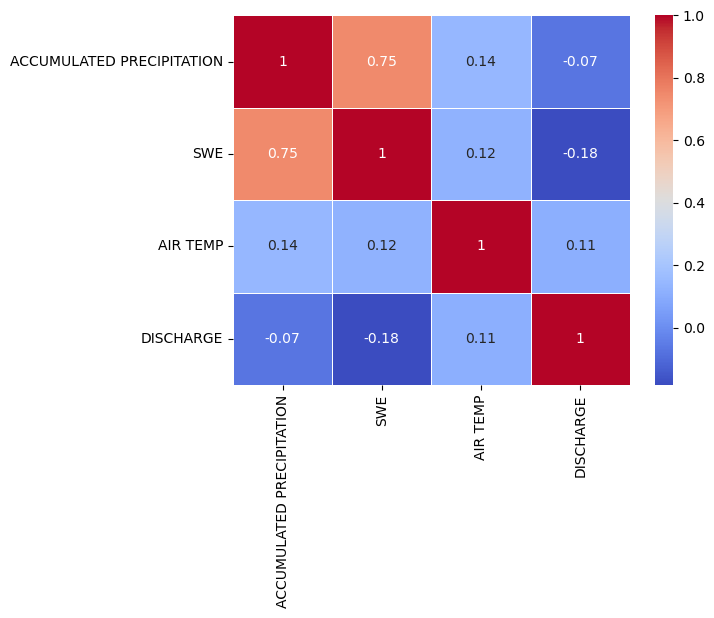

In [85]:
data_corr_matrix = hourly_cleaned.drop(['site', 'date', 'ROS'], axis=1).corr()
sns.heatmap(data_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)

## Relationship between air temp and discharge

Text(0, 0.5, 'Discharge (cubic feet/sec)')

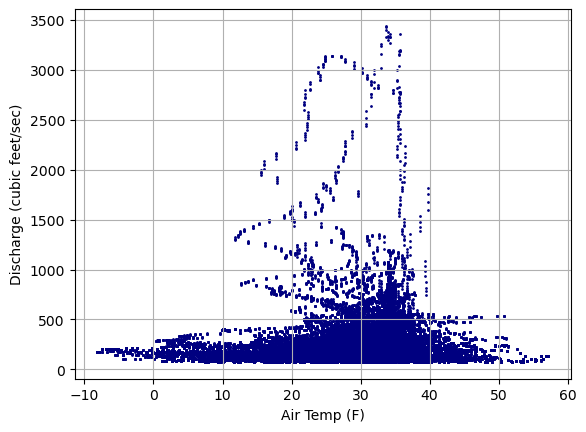

In [86]:
plt.grid()
plt.scatter(hourly_cleaned['AIR TEMP'], hourly_cleaned['DISCHARGE'], s=1, c='navy')
plt.xlabel("Air Temp (F)")
plt.ylabel("Discharge (cubic feet/sec)")

## Decision Tree Regression 
#### Predict float discharge values

In [87]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [88]:

X_data = hourly_cleaned.drop(['site', 'DISCHARGE', 'date', 'ROS'], axis =1)
X_data = X_data.to_numpy()

In [89]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE,ROS,date
0,817:WA:SNTL,31.2,15.2,12.56,247.0,False,2019-01-01 00:00:00
1,817:WA:SNTL,31.2,15.2,10.94,249.0,False,2019-01-01 00:05:00
2,817:WA:SNTL,31.2,15.2,10.94,249.0,False,2019-01-01 00:10:00
3,817:WA:SNTL,31.2,15.2,10.94,249.0,False,2019-01-01 00:15:00
4,817:WA:SNTL,31.2,15.2,10.94,247.0,False,2019-01-01 00:20:00
...,...,...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 06:45:00
118116,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:00:00
118117,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:15:00
118118,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 07:30:00


In [90]:
X_data

array([[31.2 , 15.2 , 12.56],
       [31.2 , 15.2 , 10.94],
       [31.2 , 15.2 , 10.94],
       ...,
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ]], shape=(118120, 3))

In [91]:
def run_regr(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clfr = tree.DecisionTreeRegressor(max_depth = max_depth)
    clfr.fit(X_train, y_train)
    score = clfr.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clfr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [92]:
accs = []
for i in range(1,21):
    accs.append(run_regr(X_data,hourly_cleaned['DISCHARGE'], i))

Test Score: 0.1199
Mean Squared Error: 26634.8543
Test Score: 0.1509
Mean Squared Error: 29541.1072
Test Score: 0.2115
Mean Squared Error: 27531.0289
Test Score: 0.2809
Mean Squared Error: 25358.1119
Test Score: 0.5781
Mean Squared Error: 13299.7308
Test Score: 0.5859
Mean Squared Error: 14005.2526
Test Score: 0.7103
Mean Squared Error: 9875.9547
Test Score: 0.8113
Mean Squared Error: 6572.9390
Test Score: 0.8990
Mean Squared Error: 3344.3860
Test Score: 0.9408
Mean Squared Error: 2270.7072
Test Score: 0.9489
Mean Squared Error: 1638.2255
Test Score: 0.9743
Mean Squared Error: 838.1714
Test Score: 0.9727
Mean Squared Error: 899.7190
Test Score: 0.9864
Mean Squared Error: 473.5474
Test Score: 0.9905
Mean Squared Error: 335.5779
Test Score: 0.9854
Mean Squared Error: 467.8922
Test Score: 0.9909
Mean Squared Error: 289.4661
Test Score: 0.9948
Mean Squared Error: 174.7403
Test Score: 0.9952
Mean Squared Error: 156.1044
Test Score: 0.9970
Mean Squared Error: 110.0537


Text(0, 0.5, 'Test Accuracy')

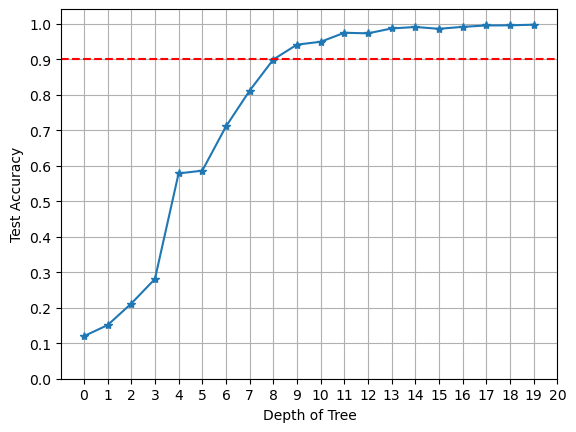

In [93]:
plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

In [94]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = X_data
y = hourly_cleaned['DISCHARGE']

# i'll do 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
clfr = tree.DecisionTreeRegressor(max_depth = 10)
clfr.fit(X_train, y_train)
clfr.score(X_test, y_test)

0.9258199693417102

In [95]:
y_pred = clfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 2711.7182


In [96]:
clfr.get_depth()

10

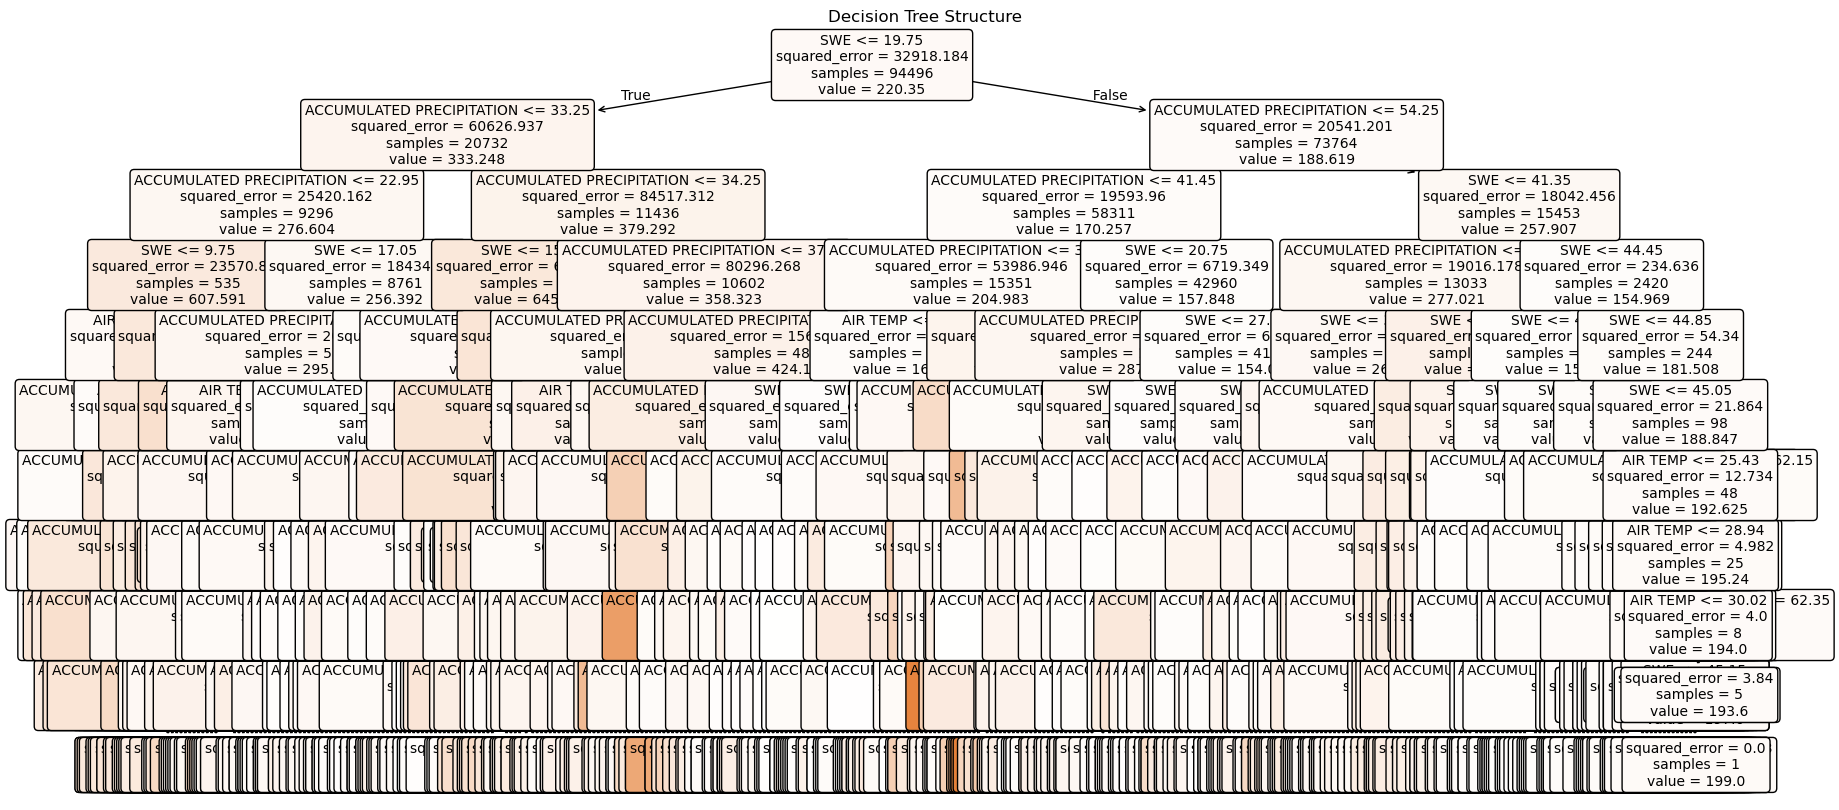

In [97]:
from sklearn.tree import plot_tree

# Visualizing decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    clfr,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()


In [98]:
y_1 = clfr.predict(X_test)

In [99]:
y_predicted = clfr.predict(X)

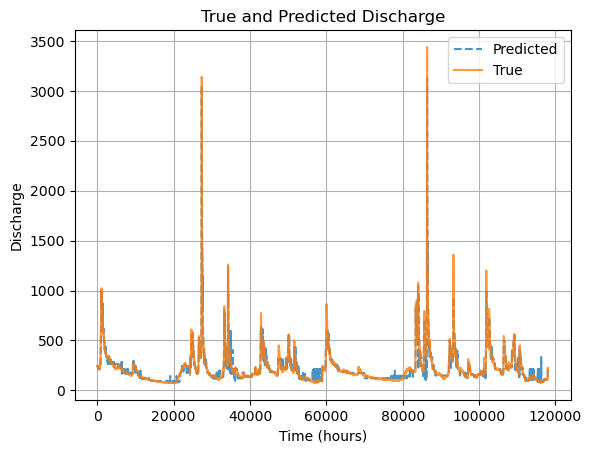

In [100]:
plt.title("True and Predicted Discharge")
#plt.plot(y_pred)
plt.plot(y_predicted, '--',label = 'Predicted', alpha = 0.8)
plt.plot(y, label = 'True', alpha = 0.8)
plt.legend()
plt.ylabel("Discharge")
plt.xlabel("Time (hours)")
plt.grid()

## Want to visualize the data with the regression line here 



In [101]:
len(hourly_cleaned['ACCUMULATED PRECIPITATION'])

118120

In [102]:
hourly_cleaned['ACCUMULATED PRECIPITATION']

0         31.2
1         31.2
2         31.2
3         31.2
4         31.2
          ... 
118115    24.1
118116    24.1
118117    24.1
118118    24.1
118119    24.1
Name: ACCUMULATED PRECIPITATION, Length: 118120, dtype: float64

In [103]:
len(X_test[:,0])

23624

## Decision Tree Classification

#### Predicts integer values 0 (snow)or 1 (rain on snow)

In [104]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE,ROS,date
0,817:WA:SNTL,31.2,15.2,12.56,247.0,False,2019-01-01 00:00:00
1,817:WA:SNTL,31.2,15.2,10.94,249.0,False,2019-01-01 00:05:00
2,817:WA:SNTL,31.2,15.2,10.94,249.0,False,2019-01-01 00:10:00
3,817:WA:SNTL,31.2,15.2,10.94,249.0,False,2019-01-01 00:15:00
4,817:WA:SNTL,31.2,15.2,10.94,247.0,False,2019-01-01 00:20:00
...,...,...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 06:45:00
118116,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:00:00
118117,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:15:00
118118,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 07:30:00


In [107]:
X_data_class

array([[31.2 , 15.2 , 12.56],
       [31.2 , 15.2 , 10.94],
       [31.2 , 15.2 , 10.94],
       ...,
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ]], shape=(118120, 3))

In [108]:
# will use sklearn's decision tree for now....

from sklearn import tree
X_data_class = hourly_cleaned.drop(["site", 'date', 'ROS', 'DISCHARGE'], axis =1).to_numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X_data_class, ground_truths.to_numpy().tolist(), test_size=0.20)

clf = tree.DecisionTreeClassifier(max_depth = 8)

# y_train_labels will be a vector of 0s and 1s from the ground_truths 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [109]:
clf.score(X_test, y_test)

0.9641889603792753

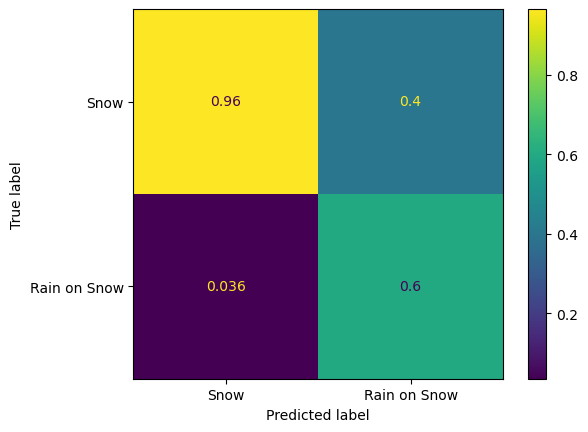

In [110]:
# add confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_true = y_test
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Snow", "Rain on Snow"])
disp.plot()
plt.show()


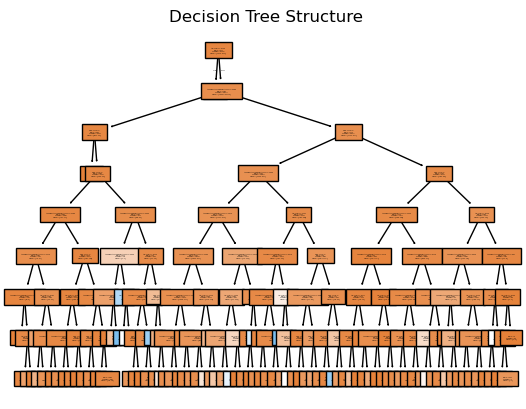

In [111]:
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=1
)
plt.title("Decision Tree Structure")
plt.show()

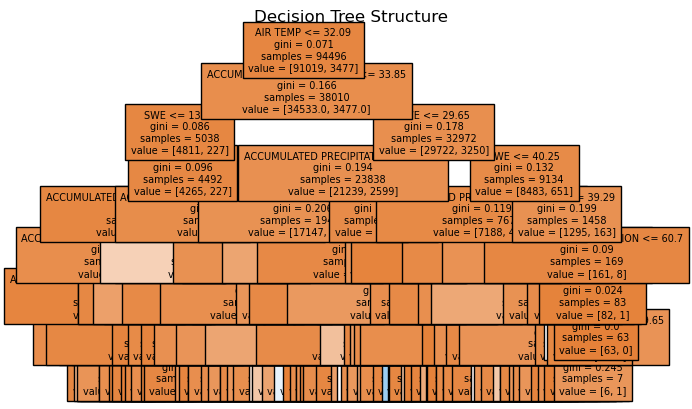

In [112]:
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=7
)
plt.title("Decision Tree Structure")
plt.show()

Text(0, 0.5, 'Test Accuracy')

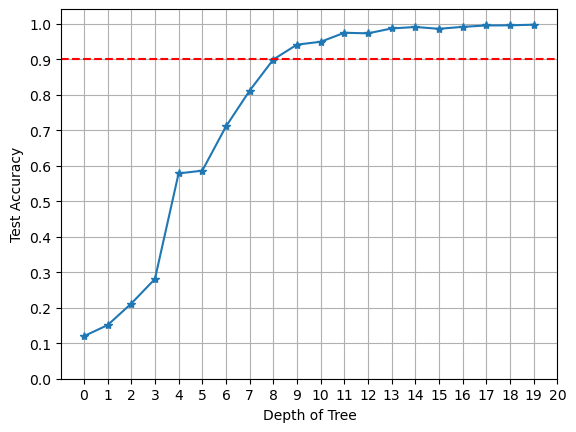

In [113]:
plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

## Tree Pruning

In [114]:
def run_class(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [115]:
accs = []
for i in range(1,21):
    accs.append(run_class(X_data_class, ground_truths.to_numpy().tolist(), i))

Test Score: 0.9629
Mean Squared Error: 0.0371
Test Score: 0.9644
Mean Squared Error: 0.0356
Test Score: 0.9647
Mean Squared Error: 0.0353
Test Score: 0.9644
Mean Squared Error: 0.0356
Test Score: 0.9636
Mean Squared Error: 0.0364
Test Score: 0.9644
Mean Squared Error: 0.0356
Test Score: 0.9639
Mean Squared Error: 0.0361
Test Score: 0.9620
Mean Squared Error: 0.0380
Test Score: 0.9627
Mean Squared Error: 0.0373
Test Score: 0.9639
Mean Squared Error: 0.0361
Test Score: 0.9633
Mean Squared Error: 0.0367
Test Score: 0.9634
Mean Squared Error: 0.0366
Test Score: 0.9636
Mean Squared Error: 0.0364
Test Score: 0.9631
Mean Squared Error: 0.0369
Test Score: 0.9631
Mean Squared Error: 0.0369
Test Score: 0.9608
Mean Squared Error: 0.0392
Test Score: 0.9613
Mean Squared Error: 0.0387
Test Score: 0.9622
Mean Squared Error: 0.0378
Test Score: 0.9623
Mean Squared Error: 0.0377
Test Score: 0.9611
Mean Squared Error: 0.0389


Text(0.5, 1.0, 'Example of possible overfitting')

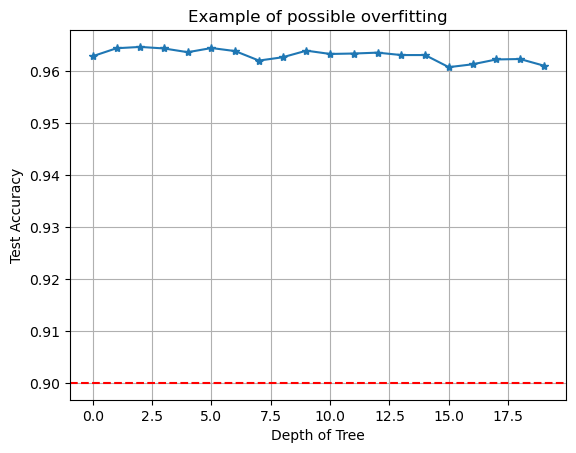

In [116]:
plt.plot(accs, '-*')
plt.grid()
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")
plt.title("Example of possible overfitting")

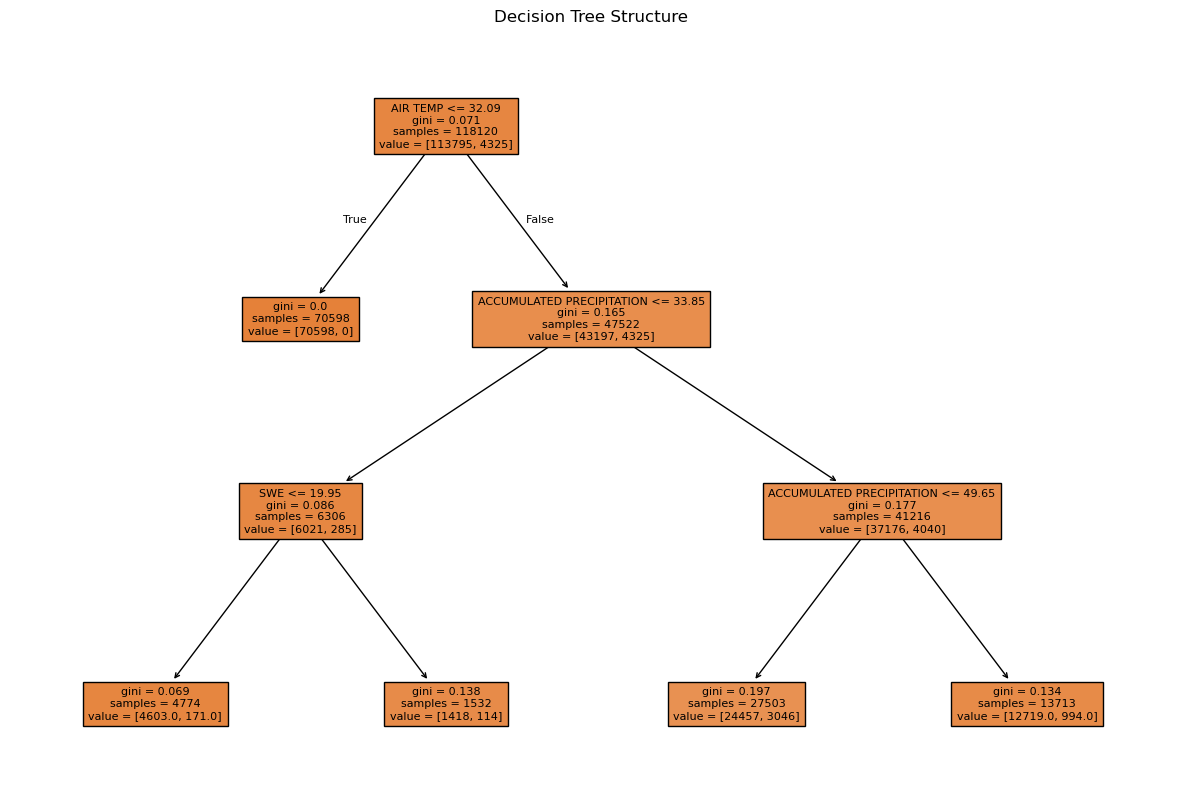

In [117]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(X_data_class, ground_truths.to_numpy().tolist())
plt.figure(figsize=(15, 10))
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=8
)
plt.title("Decision Tree Structure")
plt.show()

### Do some more thorough pruning

In [118]:
## TODO